In [1]:
!git clone https://github.com/chenmingxiang110/Growing-Neural-Cellular-Automata.git



fatal: destination path 'Growing-Neural-Cellular-Automata' already exists and is not an empty directory.


In [2]:
%cd Growing-Neural-Cellular-Automata

/home/pesquisavcl/pesquisa/filipe/automatos/Growing-Neural-Cellular-Automata


In [3]:

%matplotlib inline
import time
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output

from lib.CAModel import CAModel, LCAModel
from lib.utils_vis import SamplePool, to_alpha, to_rgb, get_living_mask, make_seed,make_custom_seed, make_circle_masks
import torch

print(torch.version.cuda)

12.1


In [4]:
def load_emoji(index, path="C:/Users/andre/OneDrive/Imagens/gato_png.png", target_size=40):
    #im = imageio.imread(path)
    im = imageio.imread(path, pilmode='RGBA')  #FILIPE
    
    #emoji = np.array(im[:, index*40:(index+1)*40].astype(np.float32))
    emoji = np.array(im.astype(np.float32))
    #emoji = cv2.resize(emoji, (40, 40))
    emoji = cv2.resize(emoji, (target_size, target_size))
    emoji /= 255.0
    return emoji

def load_recorte_emoji(index, path="C:/Users/andre/OneDrive/Imagens/gato_png.png", target_size=40):
    #im = imageio.imread(path)
    im = imageio.imread(path, pilmode='RGBA')  #FILIPE
    
    #emoji = np.array(im[:, index*40:(index+1)*40].astype(np.float32))
    emoji = np.array(im.astype(np.float32))
    #emoji = cv2.resize(emoji, (40, 40))
    #emoji = cv2.resize(emoji, (target_size, target_size))
    #emoji = emoji[:target_size][:target_size]
    emoji = emoji[0:target_size,:target_size]
    emoji /= 255.0
    return emoji

def load_recorte_target(index, path="C:/Users/andre/OneDrive/Imagens/gato_png.png", target_size=40, target_number=0, linhas_target=1, col_target=1):
    #im = imageio.imread(path)
    im = imageio.imread(path, pilmode='RGBA')  #FILIPE
    
    #emoji = np.array(im[:, index*40:(index+1)*40].astype(np.float32))
    emoji = np.array(im.astype(np.float32))
    #emoji = cv2.resize(emoji, (40, 40))
    #emoji = cv2.resize(emoji, (target_size, target_size))
    #emoji = emoji[:target_size][:target_size]
    
    
    
    #emoji = emoji[target_size*target_number:target_size*target_number+target_size,target_size*target_number:target_size*target_number+target_size]
    start_line = (target_number//linhas_target)*target_size
    end_line = start_line + target_size
    
    start_col = (target_number%col_target)*target_size
    end_col = start_col + target_size
    print(start_line, end_line, start_col, end_line)
    #emoji = emoji[target_size*target_number:target_size*target_number+target_size,target_size*target_number:target_size*target_number+target_size]
    emoji = emoji[start_line:end_line, start_col:end_col]
    emoji /= 255.0
    return emoji

def visualize_batch(x0, x):
    vis0 = to_rgb(x0)
    vis1 = to_rgb(x)
    print('batch (before/after):')
    plt.figure(figsize=[15,5])
    for i in range(x0.shape[0]):
        plt.subplot(2,x0.shape[0],i+1)
        plt.imshow(vis0[i])
        plt.axis('off')
    for i in range(x0.shape[0]):
        plt.subplot(2,x0.shape[0],i+1+x0.shape[0])
        plt.imshow(vis1[i])
        plt.axis('off')
    plt.show()

def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title('Loss history (log10)')
    plt.plot(np.log10(loss_log), '.', alpha=0.1)
    plt.show()

In [5]:
device = torch.device("cuda:0")
model_path = "models/remaster_3.pth"

CHANNEL_N = 16   # Number of CA state channels
#CHANNEL_N = 8        # Number of CA state channels
TARGET_PADDING = 4   # Number of pixels used to pad the target image border
#TARGET_PADDING = 8   # Number of pixels used to pad the target image border
TARGET_SIZE = 10

Ntargets = 9
lin_targets =3
col_targets = 3

lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)
#n_epoch = 80000
#n_epoch = 15000
n_epoch = 30000

BATCH_SIZE = 8
POOL_SIZE = 1024
#CELL_FIRE_RATE = 0.5 #testar com 1.0
CELL_FIRE_RATE = 0.2 #testar com 1.0

TARGET_EMOJI = 5 #@param "🦎"

EXPERIMENT_TYPE = "Growing"
# EXPERIMENT_TYPE = "Regenerating" #testar os tres pra ver o resultado melhor
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

/tmp/ipykernel_681262/732272190.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(path, pilmode='RGBA')  #FILIPE


0 10 0 10
0 10 10 10
0 10 20 10
10 20 0 20
10 20 10 20
10 20 20 20
20 30 0 30
20 30 10 30
20 30 20 30


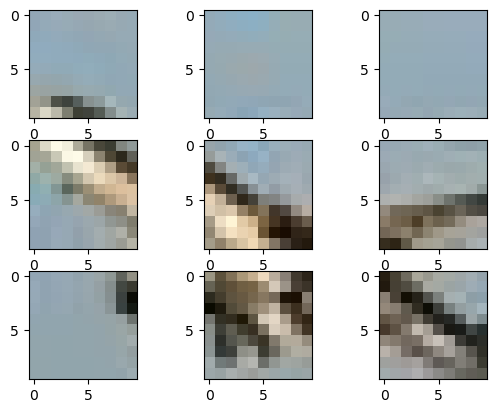

In [6]:
#target_img = load_emoji(TARGET_EMOJI, path="C:/Users/andre/OneDrive/Imagens/gato_png.png")
#nome_imagem = "caracol_png.png"
nome_imagem = "aviao40.jpg"
#target_img = load_emoji(TARGET_EMOJI, path="data/caracol_png.png", target_size=TARGET_SIZE)
#target_img = load_emoji(TARGET_EMOJI, path=f"data/{nome_imagem}", target_size=TARGET_SIZE)

#Ntargets = 2
targets_img = []

fig, axs = plt.subplots(lin_targets, col_targets)

# gs = fig.add_gridspec(3, hspace=0)
#gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
# axs = gs.subplots(sharex='col', sharey='row')

# for ax in fig.get_axes():
#     ax.label_outer()

for i in range(Ntargets):
    target_img = load_recorte_target(TARGET_EMOJI, path=f"data/{nome_imagem}", target_size=TARGET_SIZE, target_number=i,linhas_target=lin_targets, col_target=col_targets)
    targets_img.append(target_img)

    #target_img = load_recorte_emoji(TARGET_EMOJI, path=f"data/{nome_imagem}", target_size=TARGET_SIZE)
    # plt.figure(figsize=(4,4))
    # print(targets_img[i].shape)
    # plt.imshow(to_rgb(targets_img[i]))
    # plt.show()
    # print(i//lin_targets, i%col_targets)
    if Ntargets>1:
        axs[i//lin_targets, i%col_targets].imshow(to_rgb(targets_img[i]))
    else:
        plt.imshow(to_rgb(targets_img[i]))
    # axs[i//lin_targets, i%col_targets].plot(to_rgb(targets_img[i]))
    
    



In [7]:
_25425p = TARGET_PADDING

pad_targets = []
seeds = []
pools = []
batchs = []
for i in range(Ntargets):
    #pad_target = np.pad(target_img, [(_25425p, _25425p), (_25425p, _25425p), (0, 0)])
    pad_target = np.pad(targets_img[i], [(_25425p, _25425p), (_25425p, _25425p), (0, 0)])
    h, w = pad_target.shape[:2]
    pad_target = np.expand_dims(pad_target, axis=0)
    pad_target = torch.from_numpy(pad_target.astype(np.float32)).to(device)
    pad_targets.append(pad_target)


    #seed = make_seed((h, w), CHANNEL_N)
    seed = make_custom_seed((h, w), CHANNEL_N, value=i+1)
    pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
    batch = pool.sample(BATCH_SIZE).x
    
    seeds.append(seed)
    pools.append(pool)
    batchs.append(batch)

#ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device).to(device)
#ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=128).to(device)
ca = LCAModel(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=64).to(device)
#ca.load_state_dict(torch.load(model_path))




optimizer = optim.Adam(ca.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)


#filipe
# create a quantized model instance
ca2 = torch.ao.quantization.quantize_dynamic(
    ca,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)

# print(ca2.parameters())

In [8]:
model = ca
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

print(param_size, buffer_size,param_size + buffer_size)
size_all_mb = (param_size + buffer_size) / 1024**2
size_all_kb = (param_size + buffer_size) / 1024**1
print('model size: {:.3f}MB'.format(size_all_mb))
print('model size: {:.3f}KB'.format(size_all_kb))
# > model size: 44.629MB

16640 0 16640
model size: 0.016MB
model size: 16.250KB


In [9]:
import os

def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

# compare the sizes
f=print_size_of_model(ca,"fp32")
q=print_size_of_model(ca2,"int8")
print("{0:.2f} times smaller".format(f/q))

model:  fp32  	 Size (KB): 18.239
model:  int8  	 Size (KB): 7.331
2.49 times smaller


In [10]:
pad_target.shape

torch.Size([1, 18, 18, 4])

In [11]:
len(seeds)

9

30000 loss = 0.0003032674139831215
batch (before/after):


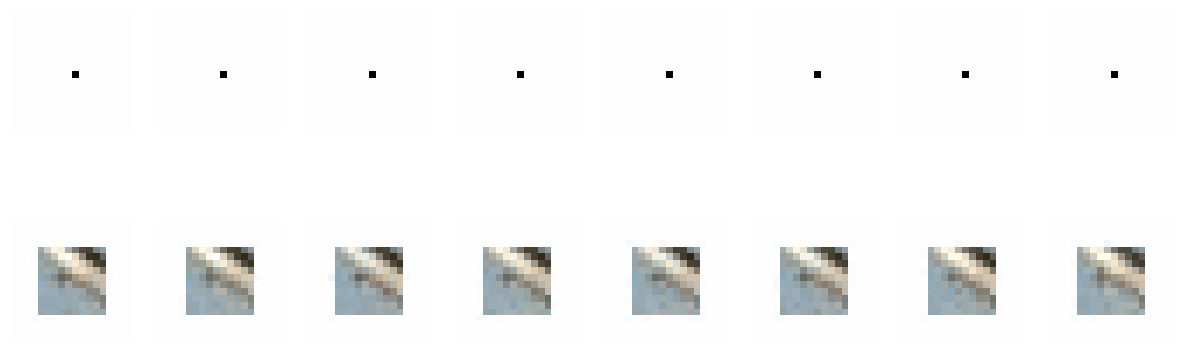

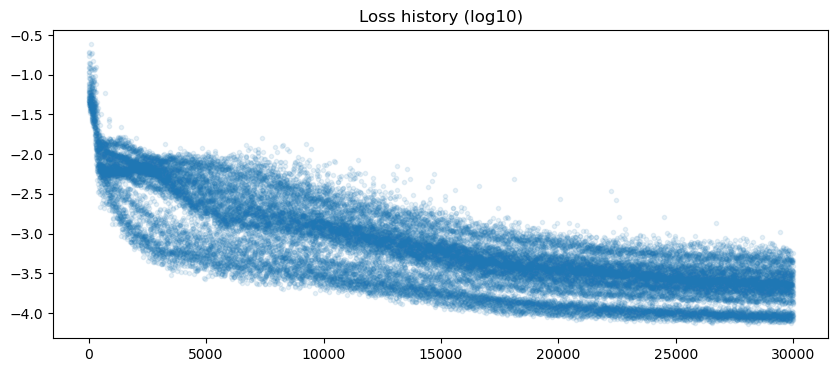

In [12]:
loss_log = []

def train(x, target, steps, optimizer, scheduler):
    x = ca(x, steps=steps)
    #import pdb;pdb.set_trace()
    if target.shape[-1]>3:
        #import pdb; pdb.set_trace()
        loss = F.mse_loss(x[:, :, :, :4], target)
    else:
        loss = F.mse_loss(x[:, :, :, :3], target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    return x, loss

def loss_f(x, target):
    if target.shape[-1]>3:
        return torch.mean(torch.pow(x[..., :4]-target, 2), [-2,-3,-1])
    else:
        return torch.mean(torch.pow(x[..., :3]-target, 2), [-2,-3,-1])

for i in range(n_epoch+1):
    recorte_id= i%Ntargets
    if USE_PATTERN_POOL:
        #batch = pool.sample(BATCH_SIZE)
        batch = pools[recorte_id].sample(BATCH_SIZE)
        #x0 = torch.from_numpy(batch.x.astype(np.float32)).to(device)
        x0 = torch.from_numpy(batchs[recorte_id].x.astype(np.float32)).to(device)
        #loss_rank = loss_f(x0, pad_target).detach().cpu().numpy().argsort()[::-1]
        loss_rank = loss_f(x0, pad_targets[recorte_id]).detach().cpu().numpy().argsort()[::-1]
        #x0 = batch.x[loss_rank]
        x0 = batchs[recorte_id].x[loss_rank]
        #x0[:1] = seed
        x0[:1] = seeds[recorte_id]
        if DAMAGE_N:
            damage = 1.0-make_circle_masks(DAMAGE_N, h, w)[..., None]
            x0[-DAMAGE_N:] *= damage
    else:
        #x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
        x0 = np.repeat(seeds[recorte_id][None, ...], BATCH_SIZE, 0)
    x0 = torch.from_numpy(x0.astype(np.float32)).to(device)
    #import pdb; pdb.set_trace()
    #x, loss = train(x0, pad_target, np.random.randint(64,96), optimizer, scheduler)
    x, loss = train(x0, pad_targets[recorte_id], np.random.randint(64,96), optimizer, scheduler)
    
    if USE_PATTERN_POOL:
        #batch.x[:] = x.detach().cpu().numpy()
        batchs[recorte_id].x[:] = x.detach().cpu().numpy()
        #batch.commit()
        batchs[recorte_id].commit()

    step_i = len(loss_log)
    loss_log.append(loss.item())

    #if step_i%100 == 0:
    if (step_i%100 == 0) or (step_i%111 == 0):
        clear_output()
        print(step_i, "loss =", loss.item())
        visualize_batch(x0.detach().cpu().numpy(), x.detach().cpu().numpy())
        plot_loss(loss_log)
        torch.save(ca.state_dict(), model_path)

## Generate image with inference

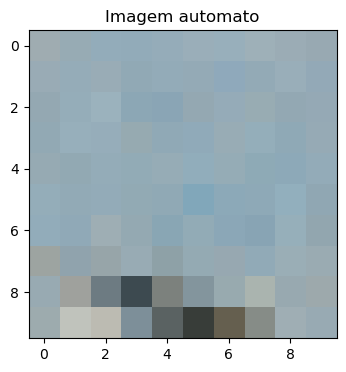

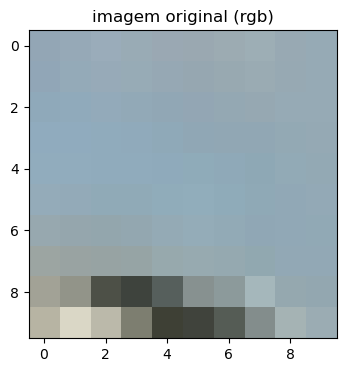

In [13]:
import tqdm

#loaded_ca = ca.load_state_dict(torch.load(model_path)).to(device)

loaded_ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=64).to(device)
#ca = LCAModel(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=8).to(device)
loaded_ca = loaded_ca.load_state_dict(torch.load(model_path))

id_recorte = 0

x = np.zeros([1, 64, 64, CHANNEL_N], np.float32)

x0 = np.repeat(seeds[id_recorte][None, ...], 1, 0)
x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

xf = ca(x0,steps=96)

#Filipe's code
#input_rgb = to_rgb(x0.detach().cpu().numpy())
output_rgb = to_rgb(xf.detach().cpu().numpy())
target_rgb = to_rgb(targets_img[id_recorte])

#unpading
output_image = output_rgb[0]
unpad_output_image = output_image[TARGET_PADDING:output_image.shape[0]-TARGET_PADDING, TARGET_PADDING:output_image.shape[1]-TARGET_PADDING]


# plt.figure(figsize=(4,4))
# plt.imshow(input_rgb[0])
# plt.title("Imagem inicial")

plt.figure(figsize=(4,4))
plt.imshow(unpad_output_image)
plt.title("Imagem automato")

plt.figure(figsize=(4,4))
#plt.imshow(to_rgb(target_img))
plt.imshow(target_rgb)
plt.title("imagem original (rgb)")
plt.show()


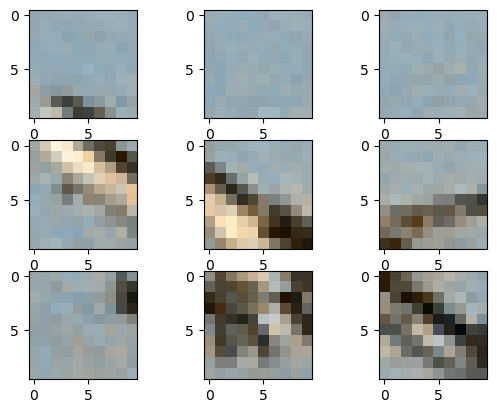

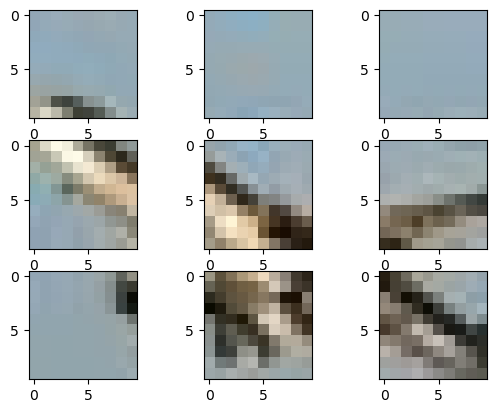

In [14]:
import tqdm

#loaded_ca = ca.load_state_dict(torch.load(model_path)).to(device)

loaded_ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=64).to(device)
#ca = LCAModel(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=8).to(device)
loaded_ca = loaded_ca.load_state_dict(torch.load(model_path))

fig1, axs1 = plt.subplots(lin_targets, col_targets)
fig2, axs2 = plt.subplots(lin_targets, col_targets)

output_recortes = []

for id_recorte in range(Ntargets):


    x = np.zeros([1, 64, 64, CHANNEL_N], np.float32)

    x0 = np.repeat(seeds[id_recorte][None, ...], 1, 0)
    x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

    xf = ca(x0,steps=96)

    #Filipe's code
    #input_rgb = to_rgb(x0.detach().cpu().numpy())
    output_rgb = to_rgb(xf.detach().cpu().numpy())
    target_rgb = to_rgb(targets_img[id_recorte])

    #unpading
    output_image = output_rgb[0]
    unpad_output_image = output_image[TARGET_PADDING:output_image.shape[0]-TARGET_PADDING, TARGET_PADDING:output_image.shape[1]-TARGET_PADDING]

    output_recortes.append(unpad_output_image)
    # plt.figure(figsize=(4,4))
    # plt.imshow(input_rgb[0])
    # plt.title("Imagem inicial")

#     plt.figure(figsize=(4,4))
#     plt.imshow(unpad_output_image)
#     plt.title("Imagem automato")

#     plt.figure(figsize=(4,4))
#     #plt.imshow(to_rgb(target_img))
#     plt.imshow(target_rgb)
#     plt.title("imagem original (rgb)")
#     plt.show()

    

    axs1[id_recorte//lin_targets, id_recorte%col_targets].imshow(unpad_output_image)
    axs2[id_recorte//lin_targets, id_recorte%col_targets].imshow(to_rgb(targets_img[id_recorte]))

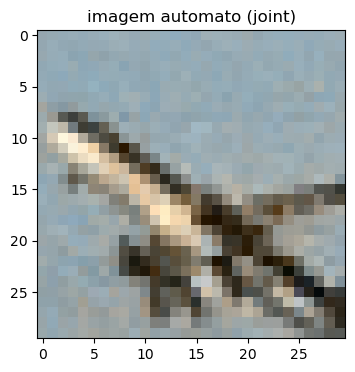

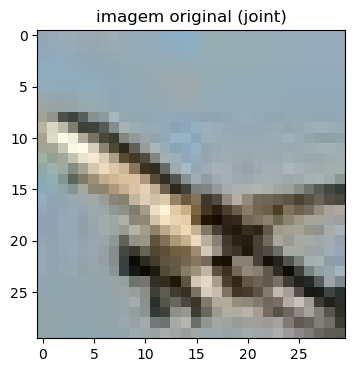

In [15]:
len(output_recortes)

#primeira linha
output_joint = output_recortes[0]
for num_col in range(1, col_targets):
    output_joint = np.concatenate((output_joint, output_recortes[num_col]), axis=1)
    
#proximas linhas
for num_lin in range(1,lin_targets):
    
    temp_joint = output_recortes[num_lin*col_targets]
    for num_col in range(1, col_targets):
        temp_joint = np.concatenate((temp_joint, output_recortes[(num_lin*col_targets)+num_col]), axis=1)
    output_joint = np.concatenate((output_joint, temp_joint), axis=0)
#joint_output = np.concatenate((output_recortes[0], output_recortes[1]), axis=1)

plt.figure(figsize=(4,4))
plt.imshow(output_joint)
plt.title("imagem automato (joint)")
plt.show()


## Target joint

#primeira linha
target_joint = targets_img[0]
for num_col in range(1, col_targets):
    target_joint = np.concatenate((target_joint, targets_img[num_col]), axis=1)
    
#proximas linhas
for num_lin in range(1,lin_targets):
    
    temp_joint = targets_img[num_lin*col_targets]
    for num_col in range(1, col_targets):
        temp_joint = np.concatenate((temp_joint, targets_img[(num_lin*col_targets)+num_col]), axis=1)
    target_joint = np.concatenate((target_joint, temp_joint), axis=0)
#joint_output = np.concatenate((output_recortes[0], output_recortes[1]), axis=1)

plt.figure(figsize=(4,4))
plt.imshow(to_rgb(target_joint))
plt.title("imagem original (joint)")
plt.show()

In [47]:
from PIL import Image

unpad_output_image_ = unpad_output_image * 255
unpad_output_image_ = unpad_output_image_.astype(np.uint8)
im = Image.fromarray(unpad_output_image_)
im.save("data/automato.png", "PNG")


temp = to_rgb(target_img)* 255
temp_ = temp.astype(np.uint8)
im2 = Image.fromarray(temp_)
# im2 = Image.fromarray(target_img)
im2.save("data/target.png", "PNG")

In [48]:
import os
print(os.stat("data/automato.png").st_size)
print(os.stat("data/target.png").st_size)
print(os.stat("data/caracol_png.png").st_size)

7142
2396
26369


In [ ]:
from PIL import Image


unpad_output_image_ = unpad_output_image * 255
unpad_output_image_ = unpad_output_image_.astype(np.uint8)
im = Image.fromarray(unpad_output_image_)
im.save("img_automato_rgb_peru_R.png", "PNG")


target_image_ = to_rgb(target_img) * 255
target_image_ = target_image_.astype(np.uint8)
im = Image.fromarray(target_image_)
im.save("img_target_rgb_peru_R.png", "PNG")

import shutil


caminho_img_automato = "img_automato_rgb_peru_R.png"
caminho_img_original = "img_target_rgb_peru_R.png"


diretorio_destino = "C:/Users/andre/OneDrive/Imagens/imagem automatos"


shutil.move(caminho_img_automato, diretorio_destino)
shutil.move(caminho_img_original, diretorio_destino)


In [ ]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
import os


imagem_automato = imread("C:/Users/andre/OneDrive/Imagens/imagem automatos/img_automato_rgb_peru_R.png")
imagem_original = imread("C:/Users/andre/OneDrive/Imagens/imagem automatos/img_target_rgb_peru_R.png")



mse = mean_squared_error(imagem_original, imagem_automato)
psnr = peak_signal_noise_ratio(imagem_original, imagem_automato)
ssim = structural_similarity(imagem_original, imagem_automato, win_size=3, multichannel=True)


print("PSNR (Peak Signal-to-Noise Ratio):", psnr)
print("MSE (Mean Squared Error):", mse)
print("SSIM (Structural Similarity Index):", ssim)

import os


caminho_img_original = "C:/Users/andre/OneDrive/Imagens/imagem automatos/img_target_rgb_peru_R.png"
caminho_img_automato = "C:/Users/andre/OneDrive/Imagens/imagem automatos/img_automato_rgb_peru_R.png"


def tamanho_arquivo(caminho):
    return os.path.getsize(caminho)


tamanho_original = tamanho_arquivo(caminho_img_original)
tamanho_automato = tamanho_arquivo(caminho_img_automato)


print("Tamanho da imagem original:", tamanho_original, "bytes")
print("Tamanho da imagem gerada pelo autômato:", tamanho_automato, "bytes")

def calcular_bits_por_pixel(caminho_imagem, tamanho_arquivo):
    imagem = imread(caminho_imagem)
    largura, altura, _ = imagem.shape
    total_pixels = largura * altura
    bits_por_pixel = (tamanho_arquivo * 8) / total_pixels
    return bits_por_pixel

bits_por_pixel_original = calcular_bits_por_pixel(caminho_img_original, tamanho_original)
bits_por_pixel_automato = calcular_bits_por_pixel(caminho_img_automato, tamanho_automato)

print("Bits por Pixel da imagem original:", bits_por_pixel_original)
print("Bits por Pixel da imagem gerada pelo autômato:", bits_por_pixel_automato)
